In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import f_oneway
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Set random seed for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

In [4]:
# Load data
df = pd.read_excel('../Data/processed/firearm_data_cleaned_new.xlsx')

In [5]:
df.head()

,year,state,rate,deaths,state_name,law_strength_score,restrictive_laws,permissive_laws,total_law_changes,rate_change,law_strength_change,unique_law_classes,strength_background_checks,strength_carrying_a_concealed_weapon_ccw,strength_castle_doctrine,strength_dealer_license,strength_firearm_sales_restrictions,strength_local_laws_preempted_by_state,strength_minimum_age,strength_prohibited_possessor,strength_registration,strength_waiting_period,strength_firearm_removal_at_scene_of_domestic_violence,strength_firearms_in_college_university,strength_child_access_laws,strength_gun_trafficking,strength_open_carry,strength_required_reporting_of_lost_or_stolen_firearms,strength_safety_training_required,strength_untraceable_firearms,strength_permit_to_purchase,strength_firearms_in_k_12_educational_settings
0,2014,AK,19.2,145,Alaska,11,18,7,25,NaN,NaN,9,2,-1,-4,0,3,-1,7,2,0,2,1,0,0,0,0,0,0,0,0,0
1,2015,AK,23.4,177,Alaska,11,18,7,25,4.2,0.0,9,2,-1,-4,0,3,-1,7,2,0,2,1,0,0,0,0,0,0,0,0,0
2,2016,AK,23.3,177,Alaska,11,18,7,25,-0.1,0.0,9,2,-1,-4,0,3,-1,7,2,0,2,1,0,0,0,0,0,0,0,0,0
3,2017,AK,24.5,180,Alaska,11,18,7,25,1.2,0.0,9,2,-1,-4,0,3,-1,7,2,0,2,1,0,0,0,0,0,0,0,0,0
4,2018,AK,21.0,155,Alaska,11,18,7,25,-3.5,0.0,9,2,-1,-4,0,3,-1,7,2,0,2,1,0,0,0,0,0,0,0,0,0


In [6]:
print(f'Dataset Shape: {df.shape}')
print(f'Years Covered: {df['year'].min()} to {df['year'].max()}')

Dataset Shape: (502, 32)
Years Covered: 2014 to 2023


## Research Question 1
### Can we predict firearm death rates based on gun law characteristics?

In [ ]:
# Get relevant columns for modeling
model_data = df[['rate', 'year', 'state', 'state_name', 'law_strength_score',
                 'restrictive_laws', 'permissive_laws']]
model_data.head()

,rate,year,state,state_name,law_strength_score,restrictive_laws,permissive_laws
0,19.2,2014,AK,Alaska,11,18,7
1,23.4,2015,AK,Alaska,11,18,7
2,23.3,2016,AK,Alaska,11,18,7
3,24.5,2017,AK,Alaska,11,18,7
4,21.0,2018,AK,Alaska,11,18,7


<Axes: >

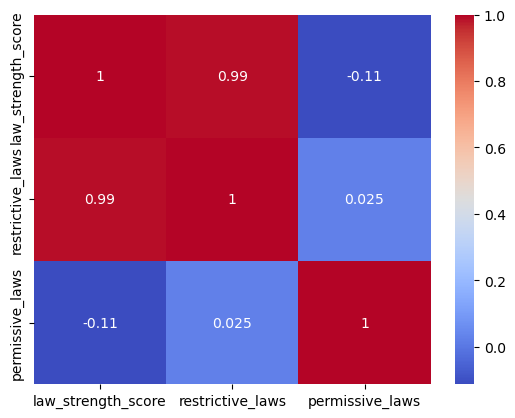

In [8]:
# Check multicollinearity
corr_matrix = model_data[['law_strength_score', 'restrictive_laws', 'permissive_laws']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

High correlation between `law_strength_score` and `restrictive_laws` because `law_strength_score` = `restrictive_laws` - `permissive_laws`. Will exclude `law_strength_score` from model becuase of redundancy. 